In [1]:
!pip install numpy mido pygame --quiet

In [2]:
import numpy
print("NumPy è stato importato correttamente!")

NumPy è stato importato correttamente!


In [3]:
# Installazione delle librerie necessarie
!pip install numpy
!pip install mido
!pip install pygame
!pip install matplotlib
!pip install pandas

In [4]:
import numpy as np
import random
from mido import Message, MidiFile, MidiTrack, tempo2bpm
from typing import List, Dict, Any, Tuple
import time
import mido
from mido import Message, MidiFile, MidiTrack

In [5]:
# MIDI Note numbers per la scala di Do maggiore (C4 a B4)
PITCH_RANGE = list(range(60, 72))  # Da C4 (60) a B4 (71)
MAX_VELOCITY = 100                 # Intensità del suono
NOTE_DURATION = 0.5                # Durata di base in secondi
DURATION_SET = [0.25, 0.5, 1.0]  # croma, semiminima, minima

In [6]:
# Progressione di accordi (I-IV-V-I in C maggiore)
CHORD_PROGRESSION = [60, 65, 67, 60] * 2  # C, F, G, C ripetuto

# Dizionario degli accordi validi
ACCORDI_VALIDI = {
    60: [60, 64, 67, 72],  # C Maj (C, E, G, C)
    65: [65, 69, 72, 77],  # F Maj (F, A, C, F)
    67: [67, 71, 74, 79],  # G Maj (G, B, D, G)
}


In [7]:
DEBUG_MUTATION = False  # Imposta a True se vuoi vedere le mutazioni
DEBUG = False
POPULATION_SIZE = 100                     # Numero di individui per generazione
MELODY_LENGTH = len(CHORD_PROGRESSION) * 4  # Lunghezza della melodia (32 note)
GENERATIONS = 50                          # Numero di generazioni
MUTATION_RATE = 0.10                      # Tasso di mutazione
CROSSOVER_RATE = 0.7          
# Tasso di crossover

MIN_PITCH = min(PITCH_RANGE)
MAX_PITCH = max(PITCH_RANGE)

MIN_VELOCITY = 50   # o il valore minimo che usi nel tuo progetto
MAX_VELOCITY = 100  # o il valore massimo che usi nel tuo progetto
# Pesi della funzione di fitness
W_HARMONY = 1.0
W_FLUIDITY = 1.5
W_VARIANCE = 0.5
W_REPETITION = 0.3
W_VELOCITY_PENALTY = 0.2


In [8]:
# Genoma: un array di tuple, dove ogni tupla è (pitch, velocity) per una nota.
# Non ottimizziamo la durata (duration) per mantenere la semplicità.
# L'individuo sarà un dizionario simile a quelli usati nei tuoi notebook.
# Esempio di genoma: [(60, 90), (62, 85), (64, 90), ...]

def create_random_genoma(length: int) -> List[Tuple[int, int]]:
    """Crea un genoma (melodia) casuale della lunghezza specificata."""
    genoma = []
    for _ in range(length):
        pitch = random.choice(PITCH_RANGE)
        velocity = random.randint(50, MAX_VELOCITY)
        duration_index = random.randint(0, len(DURATION_SET) - 1)
        genoma.append((pitch, velocity, duration_index))
    return genoma

def initialize_population(size: int) -> List[Dict[str, Any]]:
    """Inizializza la popolazione iniziale di genomi."""
    population = []
    for _ in range(size):
        population.append({
            'genoma': create_random_genoma(MELODY_LENGTH),
            'fitness': 0.0 # Verrà calcolata
        })
    return population

In [9]:
def calculate_fitness(genoma: List[Tuple[int, int]]) -> Tuple[float, float, float]:
    """
    Calcola il punteggio di fitness di un individuo (melodia).
    Restituisce: (score armonico, score fluidità, score totale)
    """
    fitness_score = 0.0
    harmony_score = 0.0
    fluidity_score = 0.0

    # 1. Armonia (Coerenza con gli Accordi Target)
    for i, (pitch, velocity, duration_index) in enumerate(genoma):
        chord_index = i // 4
        target_chord_root = CHORD_PROGRESSION[chord_index]
        valid_notes = ACCORDI_VALIDI.get(target_chord_root, [])

        if pitch in valid_notes:
            harmony_score += 10.0
        else:
            harmony_score -= 5.0

    fitness_score += harmony_score * W_HARMONY

    # 2. Fluidità (salti melodici)
    for i in range(1, MELODY_LENGTH):
        pitch_prev = genoma[i-1][0]
        pitch_curr = genoma[i][0]
        pitch_difference = abs(pitch_curr - pitch_prev)

        if pitch_difference > 5:
            fluidity_score -= (pitch_difference - 5) * 1.5

    fitness_score += fluidity_score * W_FLUIDITY

    # 3. Varianza dei pitch
    pitches = [p for p, v, d in genoma]
    pitch_variance = np.var(pitches)
    fitness_score += pitch_variance * W_VARIANCE

    durations = [DURATION_SET[d] for _, _, d in genoma]
    total_duration = sum(durations)
    
    # Bonus per varietà ritmica
    duration_variance = np.var(durations)
    fitness_score += duration_variance * 0.5  # peso arbitrario
    
    # Penalità se la melodia è troppo lunga
    if total_duration > MELODY_LENGTH * 0.5:
        fitness_score -= (total_duration - MELODY_LENGTH * 0.5) * 2.0


    # 4. Ripetizione tematica (bonus se alcune note si ripetono)
    pitch_counts = {p: pitches.count(p) for p in set(pitches)}
    repeated_notes = sum(1 for count in pitch_counts.values() if count > 1)
    fitness_score += repeated_notes * W_REPETITION
    
    # 5. Penalità per velocity troppo bassa
    velocities = [v for p, v, d in genoma]
    low_velocity_penalty = sum(1 for v in velocities if v < 60)
    fitness_score -= low_velocity_penalty * W_VELOCITY_PENALTY

    # 6. Bonus per motivi ripetuti (sequenze di 3 note)
    motivi = [tuple(pitches[i:i+3]) for i in range(len(pitches)-2)]
    motivo_counts = {m: motivi.count(m) for m in set(motivi)}
    ripetizioni_motivi = sum(1 for count in motivo_counts.values() if count > 1)
    fitness_score += ripetizioni_motivi * 0.5




    return harmony_score, fluidity_score, fitness_score


def fitness(population: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Calcola la fitness per l'intera popolazione e ordina."""
    for individual in population:
        _, _, total_score = calculate_fitness(individual['genoma'])
        individual['fitness'] = total_score
        if DEBUG:
            print(f"Fitness calcolata: {total_score}")


    population.sort(key=lambda x: x['fitness'], reverse=True)
    return population
    


In [10]:
def selection(population: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Selezione basata su un approccio ibrido: elitismo e selezione casuale pesata.
    Mantiene il 10% dei migliori e seleziona il resto da un pool pesato.
    """
    num_elite = int(POPULATION_SIZE * 0.2)
    elite = population[:num_elite]

    # Candidati da cui selezionare i genitori
    candidates = population[num_elite:]
    total_fitness = sum(i['fitness'] for i in candidates)

    if total_fitness <= 0:
        weights = [1] * len(candidates)
    else:
        weights = [i['fitness'] / total_fitness for i in candidates]

    parents = random.choices(candidates, weights=weights, k=POPULATION_SIZE - num_elite)
    return elite + parents

def crossover(population: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Applica il Single Point Crossover (come nel file 02-- Algoritmi genetici.pdf).
    """
    new_population = []

    # Manteniamo l'individuo migliore non modificato (Elitismo)
    new_population.append(population[0])

    for i in range(1, POPULATION_SIZE // 2):
        parent1 = population[i * 2]
        parent2 = population[i * 2 + 1]

        if random.random() < CROSSOVER_RATE:
            # Scegli un punto di crossover casuale
            point = random.randint(1, MELODY_LENGTH - 1)

            # Crea due nuovi figli
            child1_genoma = parent1['genoma'][:point] + parent2['genoma'][point:]
            child2_genoma = parent2['genoma'][:point] + parent1['genoma'][point:]

            new_population.append({'genoma': child1_genoma, 'fitness': 0.0})
            new_population.append({'genoma': child2_genoma, 'fitness': 0.0})
        else:
            new_population.append(parent1)
            new_population.append(parent2)

    # Assicura che la dimensione sia mantenuta
    return new_population[:POPULATION_SIZE]


def mutation(population: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    for individual in population[1:]:  # Evita il migliore
        genoma = individual['genoma']
        for i in range(len(genoma)):
            pitch, velocity, duration_index = genoma[i]

            if random.random() < MUTATION_RATE:
                # Mutazione di Pitch e Velocity (Prioritaria)
                pitch_delta = random.choice([-2, -1, 1, 2])
                new_pitch = pitch + pitch_delta
                new_pitch = max(MIN_PITCH, min(MAX_PITCH, new_pitch))

                velocity_delta = random.randint(-10, 10)
                new_velocity = velocity + velocity_delta
                new_velocity = max(MIN_VELOCITY, min(MAX_VELOCITY, new_velocity))

                genoma[i] = (new_pitch, new_velocity, duration_index)

            elif random.random() < 0.15:  # Mutazione ritmica separata
                new_duration_index = random.randint(0, len(DURATION_SET) - 1)
                genoma[i] = (pitch, velocity, new_duration_index)

    return population

File MIDI salvato come: melodia_iniziale.mid
Target melodia: 32 note, 50 generazioni.
---------------------------------------------------------
Generazione  1/50 - Fitness Max: -7.30 (Pop. attuale: -7.30)
Generazione  5/50 - Fitness Max: 6.12 (Pop. attuale: 6.12)
Generazione 10/50 - Fitness Max: 7.90 (Pop. attuale: 7.90)
Generazione 15/50 - Fitness Max: 21.45 (Pop. attuale: 21.45)
Generazione 20/50 - Fitness Max: 21.45 (Pop. attuale: 21.45)
Generazione 25/50 - Fitness Max: 21.45 (Pop. attuale: 21.45)
Generazione 30/50 - Fitness Max: 21.45 (Pop. attuale: 21.45)
Generazione 35/50 - Fitness Max: 21.45 (Pop. attuale: 21.45)
Generazione 40/50 - Fitness Max: 53.74 (Pop. attuale: 53.74)
Generazione 45/50 - Fitness Max: 53.74 (Pop. attuale: 53.74)
Generazione 50/50 - Fitness Max: 53.74 (Pop. attuale: 53.74)
---------------------------------------------------------
Evoluzione completata. Fitness finale migliore: 53.74
File MIDI salvato come: melodia_evoluta.mid
File confronto MIDI salvato come:

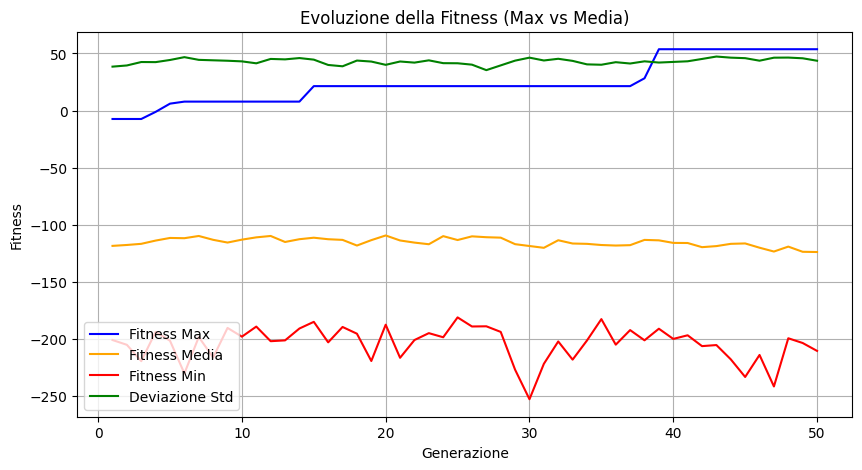

Genoma iniziale: [(62, 97, 0), (61, 65, 1), (67, 71, 2), (68, 55, 1), (69, 53, 0), (70, 65, 2), (61, 65, 0), (64, 52, 1), (71, 95, 0), (67, 88, 1), (65, 99, 1), (68, 81, 1), (71, 93, 2), (64, 71, 1), (60, 60, 2), (64, 89, 0), (62, 85, 1), (61, 94, 1), (66, 50, 1), (70, 64, 1), (65, 66, 0), (65, 82, 1), (70, 80, 0), (61, 77, 2), (62, 79, 0), (64, 81, 0), (68, 66, 0), (70, 56, 0), (61, 53, 1), (64, 92, 0), (67, 97, 1), (66, 90, 2)]
Genoma finale: [(65, 51, 2), (64, 89, 1), (67, 54, 0), (60, 54, 0), (67, 77, 2), (64, 70, 1), (65, 84, 0), (65, 90, 1), (60, 52, 2), (71, 78, 0), (71, 90, 1), (62, 50, 0), (63, 84, 0), (67, 100, 2), (61, 87, 2), (61, 52, 2), (67, 87, 0), (71, 91, 1), (67, 82, 2), (63, 98, 1), (69, 100, 2), (69, 76, 0), (71, 72, 0), (65, 76, 2), (65, 98, 0), (71, 98, 2), (61, 71, 2), (67, 100, 1), (65, 71, 0), (64, 68, 0), (67, 79, 2), (64, 50, 2)]
Note armoniche - Iniziale: 5.00, Finale: 110.00
Varianza pitch - Iniziale: 11.25, Finale: 10.87
Media salti - Iniziale: 3.61, Final

In [11]:
def create_comparison_midi(initial: List[Tuple[int, int, int]], final: List[Tuple[int, int, int]], filename="confronto.mid"):
    mid = MidiFile()

    
    track = MidiTrack()
    mid.tracks.append(track)


    tempo = mido.bpm2tempo(120)

    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    track.append(mido.Message('program_change', program=1, time=0))  # Pian

    ticks_per_beat = mid.ticks_per_beat

    for pitch, velocity, duration_index in initial:
        duration = int(DURATION_SET[duration_index] * ticks_per_beat)
        track.append(Message('note_on', note=pitch, velocity=velocity, time=0))
        track.append(Message('note_off', note=pitch, velocity=velocity, time=duration))


    # Pausa tra le due melodie
    track.append(Message('note_off', note=0, velocity=0, time=ticks_per_beat * 2))

    for pitch, velocity, duration_index in final:
        duration = int(DURATION_SET[duration_index] * ticks_per_beat)
        track.append(Message('note_on', note=pitch, velocity=velocity, time=0))
        track.append(Message('note_off', note=pitch, velocity=velocity, time=duration))


    mid.save(filename)
    print(f"File confronto MIDI salvato come: {filename}")

def create_midi_file(genoma: List[Tuple[int, int]], filename: str = "melodia_evoluta.mid"):
    """Converte il genoma (melodia) nel file MIDI riproducibile."""
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    tempo = mido.bpm2tempo(120)  # 120 BPM
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    track.append(mido.Message('program_change', program=1, time=0))  # Piano

    # Converte la durata in secondi in 'ticks' (unità MIDI)
    ticks_per_beat = mid.ticks_per_beat
    note_time = int(NOTE_DURATION * ticks_per_beat)

    # Aggiunge le note
    for pitch, velocity, duration_index in genoma:
        duration = int(DURATION_SET[duration_index] * ticks_per_beat)
        track.append(Message('note_on', note=pitch, velocity=velocity, time=0))
        track.append(Message('note_off', note=pitch, velocity=velocity, time=duration))

    mid.save(filename)
    print(f"File MIDI salvato come: {filename}")


def run_genetic_algorithm():
    """Funzione principale per eseguire l'evoluzione."""

    # Inizializza la popolazione e il genoma migliore
    popolazione = initialize_population(POPULATION_SIZE)
    popolazione = fitness(popolazione)

    initial_genome = popolazione[0]['genoma']

    # ✅ Salva la melodia iniziale prima che inizi l'evoluzione
    create_midi_file(initial_genome, filename="melodia_iniziale.mid")

    best_individual = popolazione[0]

    print(f"Target melodia: {MELODY_LENGTH} note, {GENERATIONS} generazioni.")
    print("---------------------------------------------------------")

    fitness_history = []
    import csv
    with open("fitness_evoluzione.csv", "w", newline="") as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerow(["Generazione", "Fitness Massima", "Fitness Media", "Fitness Minima", "Deviazione Std"])

    # Ciclo Evolutivo
    for generation in range(GENERATIONS):

        # 1. Selezione (per il pool di riproduzione)
        popolazione = selection(popolazione)

        # 2. Crossover (Crea nuovi individui)
        popolazione = crossover(popolazione)

        # 3. Mutazione (Introduce casualità)
        popolazione = mutation(popolazione)

        # 4. Fitness (Valuta la nuova generazione)
        popolazione = fitness(popolazione)

        fitness_history.append(popolazione[0]['fitness'])
        
        fitness_values = [ind['fitness'] for ind in popolazione]
        fitness_media = sum(fitness_values) / len(fitness_values)
        fitness_minima = min(fitness_values)
        fitness_std = np.std(fitness_values)


        with open("fitness_evoluzione.csv", "a", newline="") as f:
            writer = csv.writer(f, delimiter=';')
            writer.writerow([generation + 1, popolazione[0]['fitness'], fitness_media, fitness_minima, fitness_std])


        # 5. Aggiornamento del Migliore (Elitismo)
        if popolazione[0]['fitness'] > best_individual['fitness']:
            best_individual = popolazione[0]

        # Output dello stato
        if (generation + 1) % 5 == 0 or generation == 0:
            print(f"Generazione {generation+1:2d}/{GENERATIONS} - Fitness Max: {best_individual['fitness']:.2f} (Pop. attuale: {popolazione[0]['fitness']:.2f})")

    print("---------------------------------------------------------")
    print(f"Evoluzione completata. Fitness finale migliore: {best_individual['fitness']:.2f}")

    # Crea il file MIDI con la soluzione ottimale
    create_midi_file(best_individual['genoma'])

    create_comparison_midi(initial_genome, best_individual['genoma'])

    # Visualizza l'evoluzione della fitness
    import pandas as pd
    import matplotlib.pyplot as plt

    # Leggi il CSV con separatore corretto
    df = pd.read_csv("fitness_evoluzione.csv", sep=';')

    # Crea una nuova figura
    plt.figure(figsize=(10, 5))

    # Traccia fitness massima e media
    plt.plot(df["Generazione"], df["Fitness Massima"], label="Fitness Max", color='blue')
    plt.plot(df["Generazione"], df["Fitness Media"], label="Fitness Media", color='orange')
    plt.plot(df["Generazione"], df["Fitness Minima"], label="Fitness Min", color='red')
    plt.plot(df["Generazione"], df["Deviazione Std"], label="Deviazione Std", color='green')


    # Etichette e titolo
    plt.xlabel("Generazione")
    plt.ylabel("Fitness")
    plt.title("Evoluzione della Fitness (Max vs Media)")
    plt.legend()
    plt.grid(True)

    # Salva e mostra
    plt.savefig("grafico_fitness.png")
    plt.show()



    print("Genoma iniziale:", initial_genome)
    print("Genoma finale:", best_individual['genoma'])

    # ✅ Confronto tra melodia iniziale e finale
    # 1. Quante note erano armoniche
    initial_harmony_score = calculate_fitness(initial_genome)[0]
    final_harmony_score = calculate_fitness(best_individual['genoma'])[0]
    print(f"Note armoniche - Iniziale: {initial_harmony_score:.2f}, Finale: {final_harmony_score:.2f}")

    # 2. Varianza dei pitch
    initial_pitches = [p for p, v, d in initial_genome]
    final_pitches = [p for p, v, d in best_individual['genoma']]
    print(f"Varianza pitch - Iniziale: {np.var(initial_pitches):.2f}, Finale: {np.var(final_pitches):.2f}")

    # 3. Fluidità (salti melodici)
    initial_jumps = [abs(initial_pitches[i+1] - initial_pitches[i]) for i in range(len(initial_pitches)-1)]
    final_jumps = [abs(final_pitches[i+1] - final_pitches[i]) for i in range(len(final_pitches)-1)]
    print(f"Media salti - Iniziale: {np.mean(initial_jumps):.2f}, Finale: {np.mean(final_jumps):.2f}")


    return best_individual

# Esecuzione del progetto!
melodia_ottimale = run_genetic_algorithm()